# Processing large datasets with Apache Spark and Amazon SageMaker

***This notebook run on `Data Science 3.0 - Python 3` kernel on a `ml.t3.large` instance***.

Amazon SageMaker Processing Jobs are used  to analyze data and evaluate machine learning models on Amazon SageMaker. With Processing, you can use a simplified, managed experience on SageMaker to run your data processing workloads, such as feature engineering, data validation, model evaluation, and model interpretation. You can also use the Amazon SageMaker Processing APIs during the experimentation phase and after the code is deployed in production to evaluate performance.

        


![](https://docs.aws.amazon.com/images/sagemaker/latest/dg/images/Processing-1.png)

The preceding diagram shows how Amazon SageMaker spins up a Processing job. Amazon SageMaker takes your script, copies your data from Amazon Simple Storage Service (Amazon S3), and then pulls a processing container. The processing container image can either be an Amazon SageMaker built-in image or a custom image that you provide. The underlying infrastructure for a Processing job is fully managed by Amazon SageMaker. Cluster resources are provisioned for the duration of your job, and cleaned up when a job completes. The output of the Processing job is stored in the Amazon S3 bucket you specified.

## Our workflow for processing large amounts of data with SageMaker

We can divide our workflow into two steps:
    
1. Work with a small subset of the data with Spark running in local model in a SageMaker Studio Notebook.

1. Once we are able to work with the small subset of data we can provide the same code (as a Python script rather than a series of interactive steps) to SageMaker Processing which launched a Spark cluster, runs out code and terminates the cluster.

## In this notebook...

We will analyze the [Pushshift Reddit dataset](https://arxiv.org/pdf/2001.08435.pdf) to be used for the project and then we will run a SageMaker Processing Job to filter out the comments and submissions from subreddits of interest. The filtered data will be stored in your account's s3 bucket and it is this filtered data that you will be using for your project.

## Setup
We need an available Java installation to run pyspark. The easiest way to do this is to install JDK and set the proper paths using conda

In [2]:
# Setup - Run only once per Kernel App
%conda install openjdk -y

# install PySpark
%pip install pyspark==3.2.0

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

Retrieving notices: ...working... done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 24.3.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.3.0



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - openjdk


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2024.3.11  |       h06a4308_0         127 KB
    certifi-2024.2.2           |  py310h06a4308_0         159 KB
    openjdk-11.0.13            |       h87a67e3_0       341.0 MB
    ------------------------------------------------------------
                                           Total:       341.3 MB

The following NEW packages will be INSTALLED:

  openjdk            pkgs/main/li

In [2]:
# hide warnings
import warnings
warnings.filterwarnings("ignore")

# Import pyspark and build Spark session
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")
    .config(
        "fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.ContainerCredentialsProvider",
    )
    .getOrCreate()
)

print(spark.version)

:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-fbcbe039-c91f-460d-baf0-cf854b2f5fd0;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.2.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.563 in central
:: resolution report :: resolve 316ms :: artifacts dl 17ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.563 from central in [default]
	org.apache.hadoop#hadoop-aws;3.2.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	---------------------------------------------

3.2.0


## Process S3 data with SageMaker Processing Job `PySparkProcessor`

We are going to move the above processing code in a Python file and then submit that file to SageMaker Processing Job's [`PySparkProcessor`](https://sagemaker.readthedocs.io/en/stable/amazon_sagemaker_processing.html#pysparkprocessor).

In [4]:
!mkdir -p ./code

In [5]:
%%writefile ./code/process.py

import os
import logging
import argparse

# Import pyspark and build Spark session
from pyspark.sql.functions import *
from pyspark.sql.types import (
    DoubleType,
    IntegerType,
    StringType,
    StructField,
    StructType,
)
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

logging.basicConfig(format='%(asctime)s,%(levelname)s,%(module)s,%(filename)s,%(lineno)d,%(message)s', level=logging.DEBUG)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

def main():
    parser = argparse.ArgumentParser(description="app inputs and outputs")
    parser.add_argument("--s3_dataset_path", type=str, help="Path of dataset in S3")    
    parser.add_argument("--s3_output_bucket", type=str, help="s3 output bucket")
    parser.add_argument("--s3_output_prefix", type=str, help="s3 output prefix")
    parser.add_argument("--col_name_for_filtering", type=str, help="Name of the column to filter")
    parser.add_argument("--values_to_keep", type=str, help="comma separated list of values to keep in the filtered set")
    args = parser.parse_args()

    spark = SparkSession.builder.appName("PySparkApp").getOrCreate()
    logger.info(f"spark version = {spark.version}")
    
    # This is needed to save RDDs which is the only way to write nested Dataframes into CSV format
    sc = spark.sparkContext
    sc._jsc.hadoopConfiguration().set(
        "mapred.output.committer.class", "org.apache.hadoop.mapred.FileOutputCommitter"
    )

   
    # Downloading the data from S3 into a Dataframe
    logger.info(f"going to read {args.s3_dataset_path}")
    df = spark.read.parquet(args.s3_dataset_path, header=True)
    logger.info(f"finished reading files...")
    

    
    # filter the dataframe to only keep the values of interest
    vals = [s.strip() for s in args.values_to_keep.split(",")]
    df_filtered = df.where(col(args.col_name_for_filtering).isin(vals))
    
    # save the filtered dataframes so that these files can now be used for future analysis
    s3_path = f"s3://{args.s3_output_bucket}/{args.s3_output_prefix}"
    logger.info(f"going to write data for {vals} in {s3_path}")
    logger.info(f"shape of the df_filtered dataframe is {df_filtered.count():,}x{len(df_filtered.columns)}")
    df_filtered.write.mode("overwrite").parquet(s3_path)
    
    logger.info(f"all done...")
    
if __name__ == "__main__":
    main()

Overwriting ./code/process.py


Now submit this code to SageMaker Processing Job.

In [6]:
%%time
import time
import sagemaker
from sagemaker.spark.processing import PySparkProcessor

# Setup the PySpark processor to run the job. Note the instance type and instance count parameters. SageMaker will create these many instances of this type for the spark job.
role = sagemaker.get_execution_role()
spark_processor = PySparkProcessor(
    base_job_name="sm-spark-project",
    framework_version="3.3",
    role=role,
    instance_count=8,
    instance_type="ml.m5.xlarge",
    max_runtime_in_seconds=3600,
)

# s3 paths
session = sagemaker.Session()
bucket = session.default_bucket()
output_prefix_logs = f"spark_logs"

# modify this comma separated list to choose the subreddits of interest
subreddits = "worldnews, AutoNewspaper. phnewsfeed, newsbotbot, news"
configuration = [
    {
        "Classification": "spark-defaults",
        "Properties": {"spark.executor.memory": "12g", "spark.executor.cores": "4"},
    }
]

# the dataset contains data for these 3 years
year_list = [2021,2022,2023]

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
CPU times: user 3.2 s, sys: 431 ms, total: 3.63 s
Wall time: 3.76 s


In [7]:
%%time
for yyyy in year_list:
    print(f"going to filter comments data for year={yyyy}")
    s3_dataset_path_commments = f"s3://bigdatateaching/reddit-parquet/comments/year={yyyy}/month=*/*.parquet" # "s3a://bigdatateaching/reddit/parquet/comments/yyyy=*/mm=*/*comments*.parquet"
    output_prefix_data_comments = f"project/comments/yyyy={yyyy}"
    col_name_for_filtering = "subreddit"
    subreddits = "worldnews, AutoNewspaper. phnewsfeed, newsbotbot, news"

    # run the job now, the arguments array is provided as command line to the Python script (Spark code in this case).
    spark_processor.run(
        submit_app="./code/process.py",
        arguments=[
            "--s3_dataset_path",
            s3_dataset_path_commments,
            "--s3_output_bucket",
            bucket,
            "--s3_output_prefix",
            output_prefix_data_comments,
            "--col_name_for_filtering",
            col_name_for_filtering,
            "--values_to_keep",
            subreddits,
        ],
        spark_event_logs_s3_uri="s3://{}/{}/spark_event_logs".format(bucket, output_prefix_logs),
        logs=False,
        configuration=configuration
    )
    # give some time for resources from this iterations to get cleaned up
    # if we start the job immediately we could get insufficient resources error
    time.sleep(60)

going to filter comments data for year=2021


INFO:sagemaker:Creating processing-job with name sm-spark-project-2024-04-01-00-37-25-593


........................................................................................................................................................................................................!

INFO:sagemaker:Creating processing-job with name sm-spark-project-2024-04-01-00-55-26-867


going to filter comments data for year=2022
................................................................................................................................................................................................................!

INFO:sagemaker:Creating processing-job with name sm-spark-project-2024-04-01-01-14-07-996


going to filter comments data for year=2023
................................................................................................................!CPU times: user 2.68 s, sys: 355 ms, total: 3.04 s
Wall time: 47min 16s


In [ ]:
%%time
for yyyy in year_list:
    print(f"going to filter submissions data for year={yyyy}")
    s3_dataset_path_submissions = f"s3://bigdatateaching/reddit-parquet/submissions/year={yyyy}/month=*/*.parquet" # "s3a://bigdatateaching/reddit/parquet/submissions/yyyy=*/mm=*/*submissions*.parquet"
    output_prefix_data_submissions = f"project/submissions/yyyy={yyyy}"

    # run the job now, the arguments array is provided as command line to the Python script (Spark code in this case).
    spark_processor.run(
        submit_app="./code/process.py",
        arguments=[
             "--s3_dataset_path",
            s3_dataset_path_submissions,
            "--s3_output_bucket",
            bucket,
            "--s3_output_prefix",
            output_prefix_data_submissions,
            "--col_name_for_filtering",
            col_name_for_filtering,
            "--values_to_keep",
            subreddits,
        ],
        spark_event_logs_s3_uri="s3://{}/{}/spark_event_logs".format(bucket, output_prefix_logs),
        logs=False,
        configuration=configuration
    )
    # give some time for resources from this iterations to get cleaned up
    # if we start the job immediately we could get insufficient resources error
    time.sleep(60)

INFO:sagemaker:Creating processing-job with name sm-spark-project-2024-04-01-01-31-21-840


going to filter submissions data for year=2021
.............................................................................................................................................................................................................................!

INFO:sagemaker:Creating processing-job with name sm-spark-project-2024-04-01-01-51-08-849


going to filter submissions data for year=2022
..................................................................................................................................................!

INFO:sagemaker:Creating processing-job with name sm-spark-project-2024-04-01-02-12-57-661


going to filter submissions data for year=2023
...........................................................................................................................!CPU times: user 2.9 s, sys: 422 ms, total: 3.32 s
Wall time: 53min 5s


## Read the filtered data

Now that we have filtered the data to only keep submissions and comments from subreddits of interest. Let us read data from the s3 path where we saved the filtered data.

In [3]:
import sagemaker
session = sagemaker.Session()
bucket = session.default_bucket()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [ ]:
%%time
import sagemaker
session = sagemaker.Session()
bucket = session.default_bucket()
output_prefix_data_comments = "project/comments/yyyy=*"
s3_path = f"s3a://{bucket}/{output_prefix_data_comments}"
#s3_path = "s3a://sagemaker-us-east-1-038932893404/project/comments/yyyy=2021/part-00000-90796409-5783-4705-92c0-27c27eda8c4c-c000.snappy.parquet"
print(f"reading comments from {s3_path}")
comments = spark.read.parquet(s3_path, header=True)
print(f"shape of the comments dataframe is {comments.count():,}x{len(comments.columns)}")

In [10]:
# check counts (ensuring all needed subreddits exist)
comments.groupBy('subreddit').count().show()

+----------+--------+
| subreddit|   count|
+----------+--------+
|      news|21525282|
| worldnews|28419317|
|newsbotbot|   25301|
+----------+--------+



In [11]:
comments.printSchema()

root
 |-- author: string (nullable = true)
 |-- author_cakeday: boolean (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- body: string (nullable = true)
 |-- can_gild: boolean (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- created_utc: timestamp (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- edited: string (nullable = true)
 |-- gilded: long (nullable = true)
 |-- id: string (nullable = true)
 |-- is_submitter: boolean (nullable = true)
 |-- link_id: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- permalink: string (nullable = true)
 |-- retrieved_on: timestamp (nullable = true)
 |-- score: long (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)



In [12]:
# display a subset of columns
comments.select("subreddit", "author", "body", "parent_id", "link_id", "id", "created_utc").show()

+---------+----------------+--------------------+----------+---------+-------+-------------------+
|subreddit|          author|                body| parent_id|  link_id|     id|        created_utc|
+---------+----------------+--------------------+----------+---------+-------+-------------------+
|worldnews|         GoBSAGo|It sounds like yo...|t1_hxntd4l|t3_swq4wo|hxntoxr|2022-02-20 03:32:52|
|worldnews| plzhelpmyspider|Yeah lol I couldn...|t1_hxmwfep|t3_swb4mv|hxntoyd|2022-02-20 03:32:52|
|worldnews|      user381035|By calling it a t...|t1_hxmov41|t3_swiv61|hxntp0s|2022-02-20 03:32:53|
|worldnews|        ywBBxNqW|About half of all...|t1_hxnp3x6|t3_swl5ok|hxntp1a|2022-02-20 03:32:53|
|worldnews|       Tymbo2350|Ukraine is not pa...|t1_hxntdpv|t3_swq9uc|hxntp23|2022-02-20 03:32:54|
|worldnews|      WaxyWingie| Potatoes, probably.|t1_hxnstn6|t3_swq9uc|hxntp2s|2022-02-20 03:32:54|
|     news|       [deleted]|           [removed]|t1_hxnhhxk|t3_swiy2n|hxntp6i|2022-02-20 03:32:55|
|worldnews

In [5]:
%%time
output_prefix_data_submissions = f"project/submissions/yyyy=*"
s3_path = f"s3a://{bucket}/{output_prefix_data_submissions}"
print(f"reading submissions from {s3_path}")
submissions = spark.read.parquet(s3_path, header=True)
print(f"shape of the submissions dataframe is {submissions.count():,}x{len(submissions.columns)}")

reading submissions from s3a://sagemaker-us-east-1-851725257127/project/submissions/yyyy=*


24/04/02 07:09:16 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties
24/04/02 07:09:23 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


shape of the submissions dataframe is 1,847,138x68
CPU times: user 143 ms, sys: 16.5 ms, total: 160 ms
Wall time: 3min


In [12]:
# check counts (ensuring all needed subreddits exist)
submissions.groupBy('subreddit').count().show()

+----------+------+
| subreddit| count|
+----------+------+
|      news|868430|
| worldnews|545826|
|newsbotbot|432882|
+----------+------+



In [14]:
# display a subset of columns
submissions.select("subreddit", "author", "title", "selftext", "created_utc", "num_comments").show()

+---------+--------------------+--------------------+---------+-------------------+------------+
|subreddit|              author|               title| selftext|        created_utc|num_comments|
+---------+--------------------+--------------------+---------+-------------------+------------+
|     news|           [deleted]|New Warp Drive Mo...|[deleted]|2021-03-30 10:52:37|           0|
|worldnews|              awjouh|مسؤول تركي لصحيفة...|         |2021-03-30 10:53:05|           0|
|worldnews|           [deleted]|The China-Iran Ax...|[deleted]|2021-03-30 10:53:18|           1|
|     news|First-Situation-1384|UNICAL CES admiss...|         |2021-03-30 10:54:26|           0|
|worldnews|           [deleted]|The China-Iran Ax...|[deleted]|2021-03-30 10:54:37|           0|
|worldnews|        radarhitnews|Double mutation o...|         |2021-03-30 10:55:08|           0|
|     news|             bustead|Attack on Asian W...|         |2021-03-30 10:55:12|           0|
|     news|     Som2ny-Officia

In [15]:
import pyspark.sql.functions as f
comments.withColumn('year', f.year(f.col('created_utc'))).filter(f.col('year') != 2022).groupBy(['subreddit','year'])\
                                                                                                 .count().show()

+----------+----+--------+
| subreddit|year|   count|
+----------+----+--------+
|      news|2021|10535835|
| worldnews|2021| 8522942|
|newsbotbot|2021|    1623|
| worldnews|2023| 2098668|
|newsbotbot|2023|     190|
|      news|2023| 1538153|
+----------+----+--------+



## Analysis on Users Information
In this section, we wonder to know which users are most active in these new subreddits?

In [6]:
from pyspark.sql.functions import count, desc, year, col

# save submissions.select("subreddit", "author") to new df to analyse author info on spark
author_df = submissions.select("subreddit", "created_utc","author")
author_df = author_df.withColumn("year", year("created_utc")) 

# filter the DataFrame for "news" subreddit
news_df = author_df.filter(author_df["subreddit"] == "news")
worldnews_df = author_df.filter(author_df["subreddit"] == "worldnews")

In [9]:
# filter the DataFrame 
news_df_filtered = news_df.groupBy("author").agg(count("*").alias("submission_count")) \
                          .filter(col("submission_count") > 5000)

# order by submission count
top_news_authors = news_df_filtered.orderBy(desc("submission_count")).limit(11)

# print result
top_news_authors.show()

+--------------------+----------------+
|              author|submission_count|
+--------------------+----------------+
|           [deleted]|          119739|
|         rajacreator|           68724|
|    popularnewsindia|           30485|
|    newsnationglobal|           17184|
|          roknonline|           15960|
|     Som2ny-Official|           14037|
|        The_Dispatch|           13240|
|First-Situation-1384|           12811|
|  AgeCompetitive4420|           11398|
|  tellygupsgup_redit|            9747|
| HindustanNewsBharat|            9550|
+--------------------+----------------+



In [13]:
news_df.printSchema()

root
 |-- subreddit: string (nullable = true)
 |-- created_utc: timestamp (nullable = true)
 |-- author: string (nullable = true)
 |-- year: integer (nullable = true)



In [16]:
# to markdown
top_news_authors_pd = top_news_authors.toPandas()

# convert Pandas DataFrame to Markdown
markdown_table_news = top_news_authors_pd.to_markdown()

print(markdown_table_news)

In [10]:
# repeat the same process for "worldnews" subreddit
# filter the DataFrame 
worldnews_df_filtered = worldnews_df.groupBy("author").agg(count("*").alias("submission_count")) \
                          .filter(col("submission_count") > 1000)

# order by submission count
top_worldnews_authors = worldnews_df_filtered.orderBy(desc("submission_count")).limit(11)

# print result
top_worldnews_authors.show()

+----------------+----------------+
|          author|submission_count|
+----------------+----------------+
|       [deleted]|          114086|
|       harryg888|           57339|
|   theworldnnews|            5509|
|   AdrienSergent|            5139|
|      Infoseven7|            5107|
|   DoremusJessup|            3999|
|    shubhamk1995|            3532|
|        USNEWS01|            3027|
|Efficient-Ad9226|            2785|
|    radarhitnews|            2625|
|       nkonsontv|            2577|
+----------------+----------------+



In [ ]:
# to markdown
top_worldnews_authors_pd = top_worldnews_authors.toPandas()

# convert Pandas DataFrame to Markdown
markdown_table_worldnews = top_worldnews_authors_pd.to_markdown()

print(markdown_table_worldnews)

In [14]:
top_news_authors_pd = top_news_authors.toPandas()

top_news_authors_pd = top_news_authors_pd.iloc[1:]


In [15]:
top_worldnews_authors_pd = top_worldnews_authors.toPandas()
top_worldnews_authors_pd = top_worldnews_authors_pd.iloc[1:]

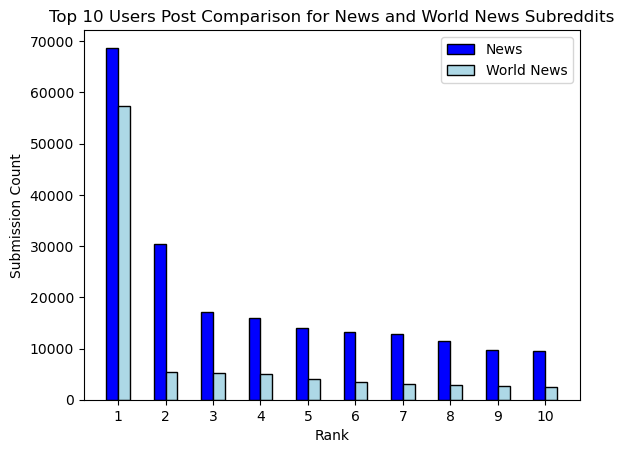

In [16]:
import numpy as np

# submission counts for news and world news
news_counts = top_news_authors_pd["submission_count"].tolist()
worldnews_counts = top_worldnews_authors_pd["submission_count"].tolist()

n = len(news_counts)

# Bar positions
r = np.arange(n)
width = 0.25

# Plotting
plt.bar(r, news_counts, color='blue', width=width, edgecolor='black', label='News')
plt.bar(r + width, worldnews_counts, color='lightblue', width=width, edgecolor='black', label='World News')

# Labels and title
plt.xlabel("Rank")
plt.ylabel("Submission Count")
plt.title("Top 10 Users Post Comparison for News and World News Subreddits")
plt.xticks(r + width/2, range(1, n+1))

# Legend
plt.legend()

# save to png
plt.savefig('../data/plots/top_users_comparison.png')

# Show plot
plt.show()
